# Resolved a sudoku thanks to CSP

Imports

In [1]:
import time
import copy
import os
from collections import deque
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Let's create the game and rules

Create the grill

In [2]:
easy_sudoku_grid = [
    [0, 0, 0, 2, 6, 0, 7, 0, 1],
    [6, 8, 0, 0, 7, 0, 0, 9, 0],
    [1, 9, 0, 0, 0, 4, 5, 0, 0],
    [8, 2, 0, 1, 0, 0, 0, 4, 0],
    [0, 0, 4, 6, 0, 2, 9, 0, 0],
    [0, 5, 0, 0, 0, 3, 0, 2, 8],
    [0, 0, 9, 3, 0, 0, 0, 7, 4],
    [0, 4, 0, 0, 5, 0, 0, 3, 0],
    [7, 0, 3, 0, 1, 8, 0, 0, 0]
]
medium_sudoku_grid = [
    [0, 0, 0, 0, 6, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 9, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 6, 0],
    [0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 8, 0, 3, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 9, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 4, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0]
]

hard_sudoku_grid = [
    [8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 6, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 9, 0, 2, 0, 0],
    [0, 5, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 4, 5, 7, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 3, 0],
    [0, 0, 1, 0, 0, 0, 0, 6, 8],
    [0, 0, 8, 5, 0, 0, 0, 1, 0],
    [0, 9, 0, 0, 0, 0, 4, 0, 0]
]

def initiate_sudoku_grid(name):
    if name == 'easy':
        return easy_sudoku_grid
    elif name == 'medium':
        return medium_sudoku_grid
    elif name == 'hard':
        return hard_sudoku_grid
    else:
        print('Invalid name of the sudoku grid. Please choose between "easy" and "hard"')
        return None


#function in order to plot the grid
def print_grid(grid): 
    print()
    for row in grid:
        print(" ".join(str(x) if x != 0 else 'x' for x in row))
    print()
print_grid(easy_sudoku_grid)

def save_grid(grid, counter,already_saved):
    
    grid_string = already_saved  +'\n' f'Grid {counter}:\n'
    for row in grid:
        grid_string += " ".join(str(x) if x != 0 else 'x' for x in row) + '\n'
    grid_string += '\n'
    return grid_string

def write_to_file(grid_string, method):
    file_path = f"./data/sudoku_grid_with_{method}.txt"
    #delete the file if it already exists
    if os.path.exists(file_path):
        os.remove(file_path)
    with open(file_path, 'a') as f:
        f.write(grid_string)


x x x 2 6 x 7 x 1
6 8 x x 7 x x 9 x
1 9 x x x 4 5 x x
8 2 x 1 x x x 4 x
x x 4 6 x 2 9 x x
x 5 x x x 3 x 2 8
x x 9 3 x x x 7 4
x 4 x x 5 x x 3 x
7 x 3 x 1 8 x x x



Now check for each case if the number can be place

In [3]:
def is_valid(grid,row,col,number):
    #check the line
    for i in range(0,9):
        if grid[row][i] == number:
            return False
    #check the column
    for i in range(0,9):
        if grid[i][col] == number:
            return False
    #check the square
    #get in which square the number is stored 
    #for the row we will get the first row of the square
    square_row = row - row % 3
    #for the column we will get the first column of the square
    square_col = col - col % 3
    #now we can check
    for i in range(square_row,square_row+3): 
        for j in range(square_col,square_col+3):#3x3 square
            if grid[i][j] == number:
                return False
            
    return True

#tests
#for row check: 2 in (0,0) should return False
print(is_valid(easy_sudoku_grid,0,0,2))
#for column check: 7 in (0,0) should return False
print(is_valid(easy_sudoku_grid,0,0,7))
#for square check: 9 in (0,0) should return False
print(is_valid(easy_sudoku_grid,0,0,9))
#For global check 3 in (0,0) should return True
print(is_valid(easy_sudoku_grid,0,0,3))


False
False
False
True


now check if the grid is completed

In [4]:
def is_completed(grid):
    for row in grid:
        if 0 in row:
            return False
    return True

## Let's start CSP

Backtracking solution baseline

In [5]:
def simple_backtracking(grid,counter,grid_string):
    #loop in each cells
    for i in range(0,9):
        for j in range(0,9):
            #check if the cells is empty or not
            if grid[i][j] == 0:
                #assign a number that is valid
                for number in range(1,10):
                    if is_valid(grid,i,j,number):
                        grid_string = save_grid(grid,counter,grid_string)
                        #if valid edit the grid and call the function recursively
                        grid[i][j] = number
                        
                        counter, solved = simple_backtracking(grid,counter+1,grid_string)
                        
                        if solved:
                            grid_string = save_grid(grid,counter,grid_string)
                            write_to_file(grid_string, 'simple_backtracking')
                            return counter,True
                        
                        #if we arrived here this means that their is no solution for the next cell to fill, so backtracking (and we switch the cell back to 0)
                        #backtracking
                        grid[i][j] = 0
                return counter,False
            
    if is_completed(grid):
        # print_grid(grid)
        grid_string = save_grid(grid,counter,grid_string)
        write_to_file(grid_string, 'simple_backtracking')
        # print(f"Solved with : {counter} iterations")
        return counter,True
    return counter,False

##  Reduction

First method for problem reduction :  Forward checking

In [6]:
def forward_checking(grid,row,col,domains):
    number = grid[row][col]
    if number != 0:
        #update the domains of the cells in the same row
        
        for i in range(9):
            if grid[row][i] == 0 and number in domains[row][i]:
                domains[row][i].remove(number)
                
        #update the domains of the cells in the same column
        for j in range (9):
            if grid[j][col] == 0 and number in domains[j][col]:
                domains[j][col].remove(number)
        
        #update the domains of the cells in the same square
        
        #for the row we will get the first row of the square
        square_row = row - row % 3
        #for the column we will get the first column of the square
        square_col = col - col % 3
        for k in range(square_row,square_row+3):
            for l in range(square_col,square_col+3):
                if grid[k][l] == 0 and number in domains[k][l]:
                    domains[k][l].remove(number)
        
    return domains

def create_domains(grid):
    # Function which creates domains at the beginning with the starting grid
    # Default domains
    domains = [[[1,2,3,4,5,6,7,8,9] for _ in range(9)] for _ in range(9)]
    
    # Loop in each cell
    for i in range(0,9):
        for j in range(0,9):
            if grid[i][j] != 0:
                number = grid[i][j]
                # Update the domains of the cells in the same row
                for k in range(9):
                    if number in domains[i][k]:
                        domains[i][k].remove(number)
                # Update the domains of the cells in the same column
                for l in range(9):
                    if number in domains[l][j]:
                        domains[l][j].remove(number)
                # Update the domains of the cells in the same square
                square_row = i - i % 3
                square_col = j - j % 3
                for m in range(square_row, square_row + 3):
                    for n in range(square_col, square_col + 3):
                        if number in domains[m][n]:
                            domains[m][n].remove(number)
    return domains



#This function allow to update back the domains when we backtrack
def update_domains(row,col,number,domains):
    #update the domains of the cells in the same row
    for i in range(9):
        if number  not in domains[row][i]:
            domains[row][i].append(number)
    #update the domains of the cells in the same column
    for j in range (9):
        if number not in domains[j][col]:
            domains[j][col].append(number)
    #update the domains of the cells in the same square
    square_row = row - row % 3
    square_col = col - col % 3
    for k in range(square_row,square_row+3):
        for l in range(square_col,square_col+3):
            if number not in domains[k][l]:
                domains[k][l].append(number)
    return domains


def find_next_empty(grid):
    for i in range(9):
        for j in range(9):
            if grid[i][j] == 0:
                return i,j
    return None,None

#WORK BUT MORE ITERATION ? WHY
def backtracking_with_forward_checking(grid,domains,counter,grid_string):


    
    row,col = find_next_empty(grid)
    # print("============================================")
    # print(f"counter : {counter}")
    # print(f"row: {row}")
    # print_grid(grid)
    # print("============================================")
    if row is None:
        grid_string = save_grid(grid,counter,grid_string)
        write_to_file(grid_string, 'backtracking_with_forward_checking')
        return counter,True
    
    for number in domains[row][col]:
        if is_valid (grid,row,col,number):
            grid_string = save_grid(grid,counter,grid_string)
            grid[row][col] = number
            new_domains = forward_checking(grid, row, col, [row[:] for row in domains])
            counter,solved = backtracking_with_forward_checking(grid,new_domains,counter+1,grid_string)
            if solved:
                grid_string = save_grid(grid,counter,grid_string)
                write_to_file(grid_string, 'backtracking_with_forward_checking')
                return counter,True
            grid[row][col] = 0
            domains = update_domains(row,col,number,domains)
    return counter,False


Second method for problem reduction :  AC-3

In [7]:
#a function in order to get the neighbors of a cell
def get_neighbors(row, col):
    #get all the cells from the columns,rows,square of the cell
    neighbors = set()
    for k in range(9):
        neighbors.add((row, k))
        neighbors.add((k, col))
    square_row, square_col = 3 * (row // 3), 3 * (col // 3)
    for i in range(square_row, square_row + 3):
        for j in range(square_col, square_col + 3):
            neighbors.add((i, j))
    neighbors.discard((row, col))  # Remove itself
    return neighbors



#a function in order to remove the inconsistent values ()
def remove_inconsistent_values(domains, row, col):
    removed = False
    # If the domain has only one value, we remove it from the neighbors
    if len(domains[row][col]) == 1:
        value = domains[row][col][0]
        for (i, j) in get_neighbors(row, col):
            if value in domains[i][j]:
                domains[i][j].remove(value)
                removed = True
    return removed


#ac3 algorithm
def ac3(domains):
    #a queue of all the arcs in the CSP
    queue = deque([(xi, xj) for xi in range(9) for xj in range(9) if len(domains[xi][xj]) > 1])
    while queue:
        (xi, xj) = queue.popleft()
        if remove_inconsistent_values(domains, xi, xj):
            if not domains[xi][xj]:  # Empty domain means fail/error
                return False
            # Add concerned neighbors to the queue
            for neighbor in get_neighbors(xi, xj):
                queue.append(neighbor)
    return True

def backtracking_with_ac3(grid, domains, counter, grid_string):
    # Step 1: Initialize domains if they haven't been passed in yet
    if domains is None:
        domains = create_domains(grid)
        if not ac3(domains):  # AC-3 preprocessing; fails if any domain becomes empty
            return counter, False

    # Step 2: Find the next empty cell for backtracking
    row, col = find_next_empty(grid)
    if row is None:  # Puzzle is solved if no empty cell remains
        print("Solution found:")
        print_grid(grid)
        grid_string = save_grid(grid, counter, grid_string)
        write_to_file(grid_string, 'backtracking_with_ac3')
        return counter, True

    # Step 3: Perform backtracking using AC-3 reduced domains
    for number in domains[row][col]:  # Iterate over possible values in the domain
        if is_valid(grid, row, col, number):
            grid[row][col] = number  # Place the number
            grid_string = save_grid(grid, counter, grid_string)

            # Make a deep copy of domains to pass to the next recursion level
            new_domains = [row[:] for row in domains]
            new_domains = update_domains(row, col, number, new_domains)  # Update domains after placing number

            # Recursive call with updated counter
            counter, solved = backtracking_with_ac3(grid, new_domains, counter + 1, grid_string)
            if solved:
                grid_string = save_grid(grid, counter, grid_string)
                write_to_file(grid_string, 'backtracking_with_ac3')
                return counter, True

            # Backtrack: remove the number and reset the cell
            grid[row][col] = 0

    return counter, False

## A basic search strategy and a Stochastic search method 

Hill Climb

In [8]:

def sub_grid_is_valid(grid,row,col,number):
    #get in which square the number is stored 
    #for the row we will get the first row of the square
    square_row = row - row % 3
    #for the column we will get the first column of the square
    square_col = col - col % 3
    #now we can check
    for i in range(square_row,square_row+3): 
        for j in range(square_col,square_col+3):#3x3 square
            if grid[i][j] == number:
                return False
            
    return True
    

def hill_climb_set_up(grid):
    working_grid = copy.deepcopy(grid)
    #generate a random grid just following the rules of subgrid, using simple backtracking
    for row in range(0,9):
        for col in range(0,9):
            if working_grid[row][col] == 0:
                used_numbers = []
                for i in range(1,10):
                    if sub_grid_is_valid(working_grid,row,col,i):
                        used_numbers.append(i)
                working_grid[row][col] = used_numbers[0]
    return working_grid


def cost(grid):
    #calculate the cost of the grid
    cost = 0
    row_cost = 0
    col_cost = 0
    
    for i in range(0,9):
        #lets check row and column problem
        row_cost = row_cost + (9 - len(set(grid[i]))) #len(set(grid[i])) give the number of unique values in the row
        col = [row[i] for row in grid] #get the i element of each row
        col_cost = col_cost + (9 - len(set(col)))
    
    cost = row_cost + col_cost
    
    #check the cost of subgrid
    subgrid_cost = 0
    for i in range(0,9,3): #i from 0 to 9 with a step of 3
        for j in range(0,9,3): #same with j
            subgrid = [grid[x][y] for x in range(i,i+3) for y in range(j,j+3)] #select all the values from each subgrid
            subgrid_cost += (9 - len(set(subgrid)))
    cost+=subgrid_cost
    # print(row_cost)
    # print(col_cost)
    # print(subgrid_cost) #should be 0 when the cost is count after the setup
    # print(cost) 
    return cost
   

                    
#we will switch value into the same subgrid          
def switch_neighbors_subgrid(original_grid,grid,grid_row,grid_col):
    new_grid = copy.deepcopy(grid)
    #extract all positions of values that can be switch (not the one in the original_grid) of the subgrid
    switchable_positions = []
    for i in range(grid_row,grid_row+3):
        for j in range(grid_col,grid_col+3):
            if original_grid[i][j] == 0:
                switchable_positions.append((i,j))
    if len(switchable_positions) < 2: #no switch possible
        print('No value to switch')
        return new_grid
    #switch two values choosen randomly
    switch_values = random.sample(switchable_positions,2)
    new_grid[switch_values[0][0]][switch_values[0][1]],new_grid[switch_values[1][0]][switch_values[1][1]] = new_grid[switch_values[1][0]][switch_values[1][1]],new_grid[switch_values[0][0]][switch_values[0][1]]
    return new_grid


def hill_climb(original_grid,max_iterations,random_moov):
    
    current_grid = hill_climb_set_up(original_grid)
    current_cost = cost(current_grid)
    for i in range(max_iterations):

        #get a random subgrid
        grid_row = random.choice([0,3,6])
        grid_col = random.choice([0,3,6])
        new_grid = switch_neighbors_subgrid(original_grid,current_grid,grid_row,grid_col)
        new_cost = cost(new_grid)

            
        #ending case
        if new_cost == 0:
            print('Solved')
            print_grid(new_grid)
            return (i,True,new_grid,cost(new_grid))
        #if the new grid is better than the current one
        if new_cost < current_cost or random.random() < random_moov:
            current_grid = new_grid
            current_cost = new_cost
            
    return (max_iterations,False,current_grid,cost(current_grid))


# solution_with_hill,iter,cost = hill_climb(medium_sudoku_grid,1000000,0.1)
# print_grid(solution_with_hill)
# print("iterations: ",iter)
# print("cost: ",cost)


    

Graph reprensentation with simple backtracking

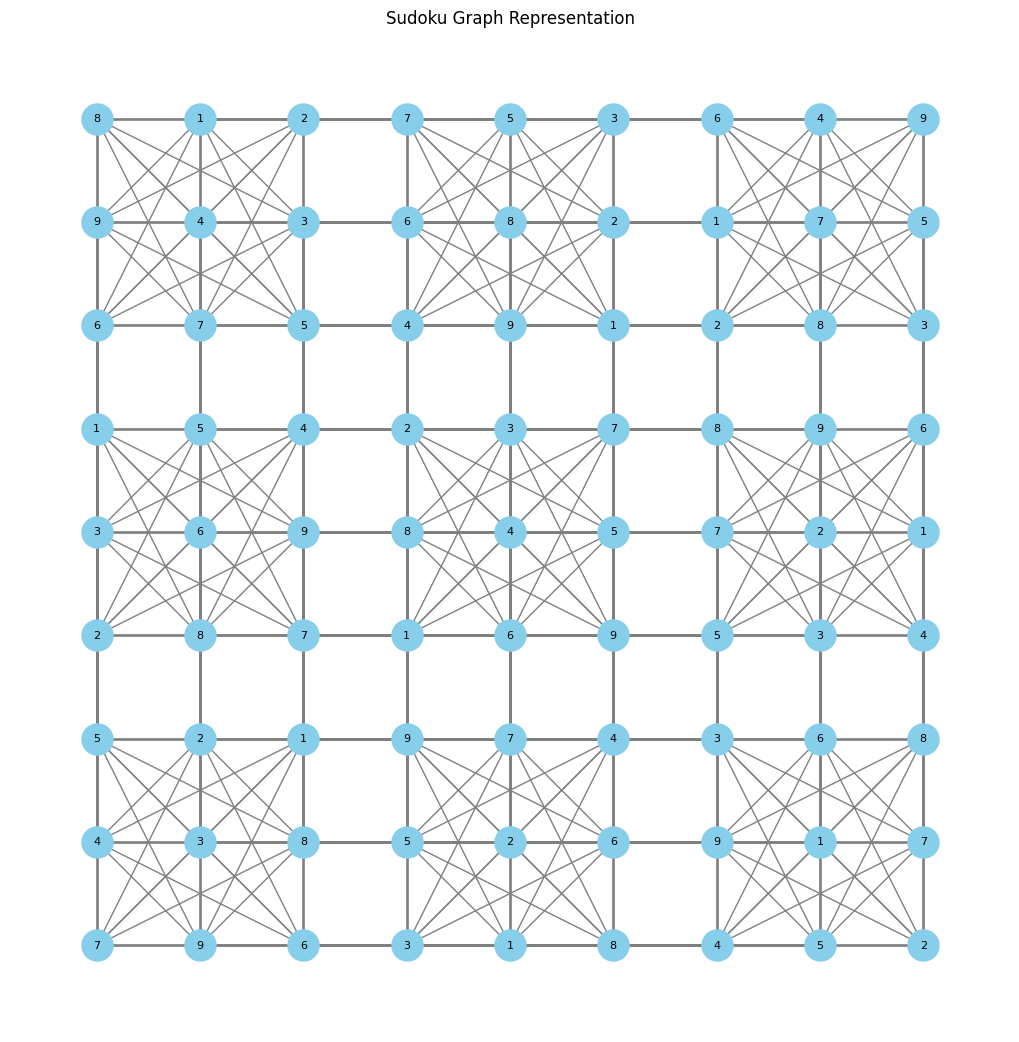

iteration test:  49558


In [11]:
def generate_the_graph(grid):
    working_grid = copy.deepcopy(grid)
    graph = {}
    #generate the nodes
    for row in range(0, 9):
        for col in range(0, 9):
            graph[(row, col)] = {
                'value': working_grid[row][col], #current value of the cell
                'neighbors': set() #future values of neighbors
            }
    #generate the relations
    for row in range(0,9):
        for col in range(0,9):
            for i in range(0,9):
                #check the row
                if i != col:
                    graph[(row,col)]['neighbors'].add((row,i))
                #check the column
                if i != row:
                    graph[(row,col)]['neighbors'].add((i,col))
            #check the subgrid
           
            square_row = row - row % 3
            square_col = col - col % 3
            #loop in the subgrid
            for r in range(square_row,square_row+3):
                for c in range(square_col,square_col+3):
                    if (r,c) != (row,col): #same principle
                        graph[(row, col)]['neighbors'].add((r, c))
    return graph

            
def plot_sudoku_graph(graph):
    G = nx.Graph()
    
    
    # Add nodes 
    for (row, col), data in graph.items():
        node_label = f"{data['value']}" 
        G.add_node((row, col), label=node_label)

    # Add edges 
    for (row, col), data in graph.items():
        for neighbor in data['neighbors']:
            G.add_edge((row, col), neighbor)
            
    # Generate positions for plotting (nodes will be in a grid layout)
    pos = {(row, col): (col, -row) for row in range(9) for col in range(9)}
            
    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=False, node_size=500, node_color="skyblue", edge_color="gray")

    # Add labels for nodes
    labels = {node: G.nodes[node]['label'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color="black")

    plt.title("Sudoku Graph Representation")
    plt.axis("off")
    plt.show()
    
    

def is_valid_graph(graph,node,value):
    for neighbor in graph[node]['neighbors']:
        if graph[neighbor]['value'] == value:
            return False
    return True


def solve_sudoku_graph(grid,iter = 0,graph=None):
    if graph is None:
        graph = generate_the_graph(grid)
    for node, data in graph.items():
        if data["value"] == 0:  # Empty cell
            # Try all possible values
            for value in range(1, 10):
                if is_valid_graph(graph, node, value):
                    graph[node]['value'] = value  # Assign the value
                    iter += 1

                    # Recursive call for the next node
                    final_graph, iter, solved = solve_sudoku_graph(grid, iter, graph)
                    if solved:
                        return final_graph, iter, True

                    # Backtrack
                    graph[node]['value'] = 0

            # No value was valid for this cell
            return graph, iter, False

    # No more empty cells; Sudoku is solved
    return graph, iter, True


                      

solved_graph, iterations, solved = solve_sudoku_graph(hard_sudoku_grid)
plot_sudoku_graph(solved_graph)
print("iteration test: ",iterations)



## Function(s) in order to compare the efficacity of each method

time and iterations

In [12]:
def measure_time_and_iterations(func,*args):
    start_time = time.time()
    iterations = func(*args)[0]
    succeed = func(*args)[1]
    end_time = time.time()
    executive_time = end_time - start_time
    return executive_time, iterations, succeed

print(measure_time_and_iterations(solve_sudoku_graph,medium_sudoku_grid))

def testing(n):
    grid_difficulties = ["easy","medium","hard"]
    diff_results ={}
    for grid_difficulty in grid_difficulties:
        methods= ['backtracking_with_forward_checking','simple_backtracking','ac3_backtracking','hill_climb','graph']
        #a dict with the results of each method for the n test
        results = {}
        
        for  method in methods:
            
            original_grid = initiate_sudoku_grid(grid_difficulty)
            if method == 'simple_backtracking':
                
                time_values =[]
                iter_values = []
                
                for _ in range(0,n):
                    grid = copy.deepcopy(original_grid)
                    grid_string = ""
                    time_iter = measure_time_and_iterations(simple_backtracking,grid,0,grid_string)
                    is_solved = time_iter[2]
                    if is_solved:
                        
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])

                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {grid_difficulty} grid with the {method} method")
                else:    
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The simple version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the sudoku for {n} tests for the {grid_difficulty} grid")
            elif method == 'backtracking_with_forward_checking':
                time_values =[]
                iter_values = []
                
                for _ in range(0,n):
                    grid = copy.deepcopy(original_grid)
                    grid_string = ""
                    domains = create_domains(grid)
                    time_iter = measure_time_and_iterations(backtracking_with_forward_checking,grid,domains,0,grid_string)
                    is_solved = time_iter[2]
                    if is_solved:
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])
                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {grid_difficulty} grid with the {method} method")
                else:
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The backtracking_with_forward_checking version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the sudoku for {n} tests for the {grid_difficulty} grid")
            elif method == 'ac3_backtracking':
                time_values =[]
                iter_values = []
                
                for _ in range(0,n):
                    grid = copy.deepcopy(original_grid)
                    grid_string = ""
                    domains = create_domains(grid)
                    time_iter = measure_time_and_iterations(backtracking_with_ac3,grid,domains,0,grid_string)
                    is_solved = time_iter[2]
                    if is_solved:
                                            
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])
                    if len(time_values) == 0:
                        results[method] = "No result found"
                        print(f"No result found for the {grid_difficulty} grid with the {method} method")
                    else:  
                        time_mean = sum(time_values)/len(time_values)
                        iter_mean = sum(iter_values)/len(iter_values)  
                        results[method] = [time_mean,iter_mean,is_solved]
                        print(f"The ac3_backtracking version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the sudoku for {n} tests for the {grid_difficulty} grid")
            elif method == 'hill_climb':
                time_values =[]
                iter_values = []
                for _ in range(0,n):
                    grid = copy.deepcopy(original_grid)
                    time_iter = measure_time_and_iterations(hill_climb,grid,1000000,0.1)
                    is_solved = time_iter[2]
                    if is_solved:
                        
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])
                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {grid_difficulty} grid with the {method} method")
                else:    
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The hill_climb version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the sudoku for {n} tests for the {grid_difficulty} grid")
            elif method =="graph":
                time_values =[]
                iter_values = []
                for _ in range(0,n):
                    grid = copy.deepcopy(original_grid)
                    graph = generate_the_graph(grid)
                    time_iter = measure_time_and_iterations(solve_sudoku_graph,graph,0)
                    is_solved = time_iter[2]
                    if is_solved:
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])
                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {grid_difficulty} grid with the {method} method")
                else:
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The graph version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the sudoku for {n} tests for the {grid_difficulty} grid")
            
        print(results)
        diff_results[grid_difficulty] = results
    df = pd.DataFrame(diff_results)
    df.to_csv('data/results.csv')
    return diff_results

testing(5)

#forward checking less efficient that normal ? only for hard not for easy and medium (put it in the report)
#ac3 dont seem to work (same result as backtracking classic everytime)
#save_grid dont have all the grids...


(0.03999686241149902, {(0, 0): {'value': 1, 'neighbors': {(4, 0), (8, 0), (0, 2), (0, 5), (2, 2), (1, 0), (0, 8), (3, 0), (5, 0), (0, 1), (0, 7), (1, 2), (0, 4), (2, 1), (7, 0), (1, 1), (0, 3), (2, 0), (0, 6), (6, 0)}}, (0, 1): {'value': 2, 'neighbors': {(3, 1), (5, 1), (0, 2), (0, 5), (2, 2), (1, 0), (0, 8), (7, 1), (0, 7), (1, 2), (0, 4), (2, 1), (6, 1), (4, 1), (0, 0), (8, 1), (1, 1), (0, 3), (2, 0), (0, 6)}}, (0, 2): {'value': 3, 'neighbors': {(0, 5), (2, 2), (1, 0), (0, 8), (6, 2), (4, 2), (8, 2), (0, 1), (0, 7), (1, 2), (0, 4), (2, 1), (3, 2), (5, 2), (0, 0), (1, 1), (0, 3), (2, 0), (0, 6), (7, 2)}}, (0, 3): {'value': 5, 'neighbors': {(4, 3), (0, 2), (8, 3), (0, 5), (0, 8), (2, 5), (1, 3), (3, 3), (5, 3), (0, 1), (0, 7), (2, 4), (0, 4), (1, 5), (7, 3), (0, 0), (1, 4), (0, 6), (2, 3), (6, 3)}}, (0, 4): {'value': 6, 'neighbors': {(3, 4), (5, 4), (0, 2), (0, 5), (0, 8), (2, 5), (1, 3), (7, 4), (0, 1), (0, 7), (2, 4), (1, 5), (6, 4), (4, 4), (8, 4), (0, 0), (0, 3), (1, 4), (0, 6), (2

KeyboardInterrupt: 